<a href="https://colab.research.google.com/github/LogBlast/projectdata_group6/blob/main/project_group6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project Submission - Group 6***

# 1) Data importation

In [145]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

df = pd.read_csv("online_gaming_behavior_dataset.csv")
display(df)

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,49029,32,Male,USA,Strategy,20.619662,0,Easy,4,75,85,14,Medium
40030,49030,44,Female,Other,Simulation,13.539280,0,Hard,19,114,71,27,High
40031,49031,15,Female,USA,RPG,0.240057,1,Easy,10,176,29,1,High
40032,49032,34,Male,USA,Sports,14.017818,1,Medium,3,128,70,10,Medium


# 2) Preprocessing

## a) Missing data and duplicates detection (data cleaning)

*The dataset doesn't contain any null values because it's intended for data processing on Kaggle, and therefore must be cleaned and free of issues.*

In [146]:
print(f"We first search for missing data :\n{df.isnull().sum()}\n") 
print(f"In addition, we look after any duplicate :\n{df.duplicated().sum}\n")

# However, we check errors in the data collecting on the following numerical columns (If > 0, the player didn't play the game !) :
critical_columns = ['PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel']

print(f"Then check for incorrect data in critical columns :\n{df.duplicated().sum}")
for column in critical_columns:
    invalid_count = (df[column] <= 0).sum()
    print(f"In '{column}', there are : {invalid_count} invalid rows.\n")

df = df[(df[critical_columns] > 0).all(axis=1)]

# We reset dataset indexes
df = df.reset_index(drop=True)

print("\nThe dataset is now clean ! Here it is :")
display(df)

We first search for missing data :
PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64

In addition, we look after any duplicate :
<bound method Series.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
40029    False
40030    False
40031    False
40032    False
40033    False
Length: 40034, dtype: bool>

Then check for incorrect data in critical columns :
<bound method Series.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
40029    False
40030    False
40031    False
40032    False
40033    False
Length: 40034, dtype: bool>
In 'PlayTi

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38062,49029,32,Male,USA,Strategy,20.619662,0,Easy,4,75,85,14,Medium
38063,49030,44,Female,Other,Simulation,13.539280,0,Hard,19,114,71,27,High
38064,49031,15,Female,USA,RPG,0.240057,1,Easy,10,176,29,1,High
38065,49032,34,Male,USA,Sports,14.017818,1,Medium,3,128,70,10,Medium


## b) Preprocessing the data & one-hot encoding

In [147]:
# Get column types
numerical_columns = df.select_dtypes(include=['number']).columns.to_list()
categorical_columns = df.select_dtypes(include=['object']).columns.to_list()

# Clean numerical values
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

# One-hot encoding categorical data
print("Then we convert categorical data into numerical one through hot encoding.")
df_dummies = pd.get_dummies(data=df[[column for column in categorical_columns if column != "EngagementLevel"]], dtype=int)

# Create final ML dataset
df_encoded = df.copy()
df_encoded = pd.concat([df[numerical_columns], df_dummies], axis=1)

# We make a copy of the dataset for visualization's manipulations
df_visu = df.copy()

# Then we apply the one-hot encoding to the main DataFrame
df = pd.concat([df, df_dummies], axis=1)

# Display results
print("Our new dataset looks like this :")
display(df_encoded.head())
print(df_encoded.info())

Then we convert categorical data into numerical one through hot encoding.
Our new dataset looks like this :


,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_Female,Gender_Male,...,Location_Other,Location_USA,GameGenre_Action,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Easy,GameDifficulty_Hard,GameDifficulty_Medium
0,9000,43,16.271119,0,6,108,79,25,0,1,...,1,0,0,0,0,0,1,0,0,1
1,9001,29,5.525961,0,5,144,11,10,1,0,...,0,1,0,0,0,0,1,0,0,1
2,9002,22,8.223755,0,16,142,35,41,1,0,...,0,1,0,0,0,1,0,1,0,0
3,9003,35,5.265351,1,9,85,57,47,0,1,...,0,1,1,0,0,0,0,1,0,0
4,9004,33,15.531945,0,2,131,95,37,0,1,...,0,0,1,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38067 entries, 0 to 38066
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   38067 non-null  int64  
 1   Age                        38067 non-null  int64  
 2   PlayTimeHours              38067 non-null  float64
 3   InGamePurchases            38067 non-null  int64  
 4   SessionsPerWeek            38067 non-null  int64  
 5   AvgSessionDurationMinutes  38067 non-null  int64  
 6   PlayerLevel                38067 non-null  int64  
 7   AchievementsUnlocked       38067 non-null  int64  
 8   Gender_Female              38067 non-null  int64  
 9   Gender_Male                38067 non-null  int64  
 10  Location_Asia              38067 non-null  int64  
 11  Location_Europe            38067 non-null  int64  
 12  Location_Other             38067 non-null  int64  
 13  Location_USA               38067 non-null  int

# 3) Data Visualization

## a) 'data' distribution

### Demographic Analysis

Age distribution

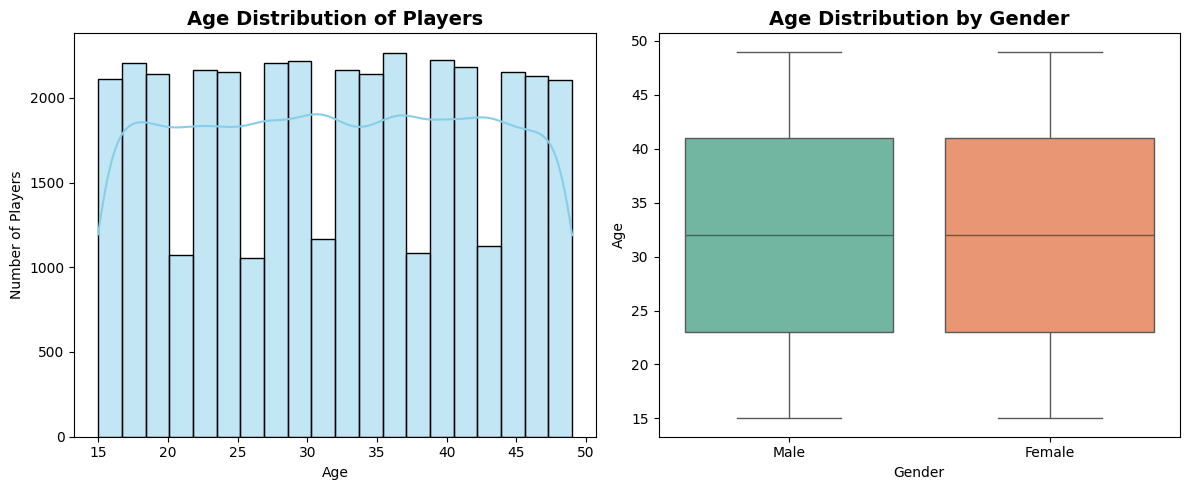

In [148]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_visu, x='Age', bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Players', fontsize=14, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Number of Players')

plt.subplot(1, 2, 2)
# Box plot by gender
sns.boxplot(data=df_visu, x='Gender', y='Age', palette='Set2', hue='Gender')
plt.title('Age Distribution by Gender', fontsize=14, fontweight='bold')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

Gender and location distribution

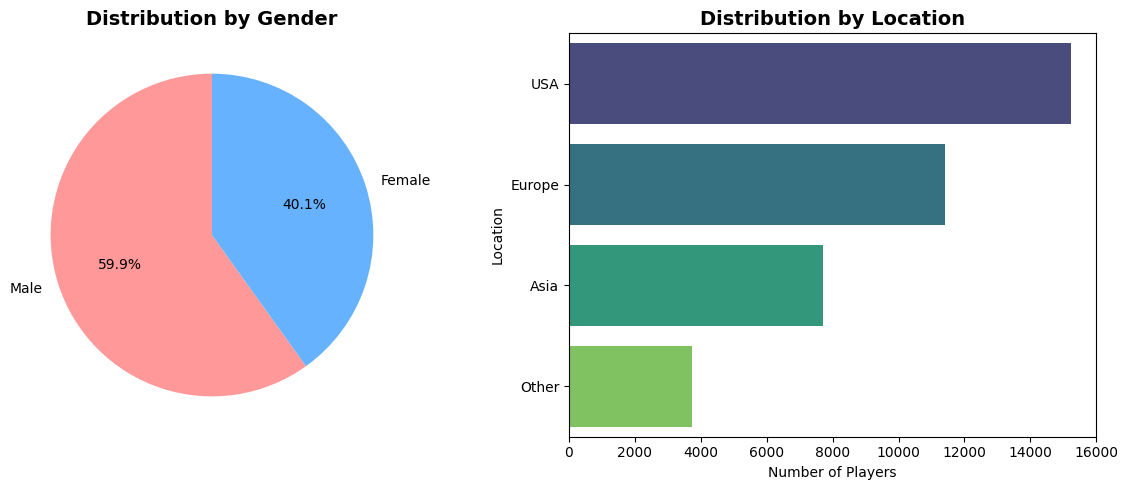

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gender
gender_counts = df_visu['Gender'].value_counts()
axes[0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
           colors=['#FF9999', '#66B2FF'], startangle=90)
axes[0].set_title('Distribution by Gender', fontsize=14, fontweight='bold')

# Location
location_counts = df_visu['Location'].value_counts()
sns.barplot(x=location_counts.values, y=location_counts.index, hue=location_counts.index, ax=axes[1], palette='viridis')
axes[1].set_title('Distribution by Location', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Players')

plt.tight_layout()
plt.show()

### Game Genre Analysis

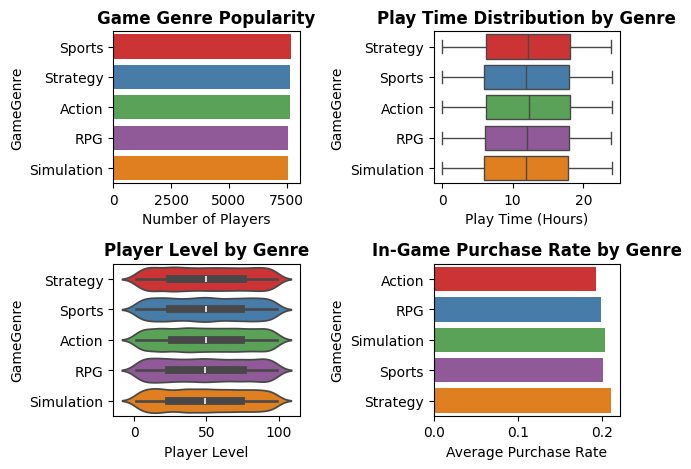

In [150]:
# Genre popularity
plt.subplot(2, 2, 1)
genre_counts = df_visu['GameGenre'].value_counts()
sns.barplot(x=genre_counts.values, y=genre_counts.index, hue=genre_counts.index, palette='Set1')
plt.title('Game Genre Popularity', fontweight='bold')
plt.xlabel('Number of Players')

# Play time by genre
plt.subplot(2, 2, 2)
sns.boxplot(data=df_visu, y='GameGenre', x='PlayTimeHours', hue='GameGenre', palette='Set1')
plt.title('Play Time Distribution by Genre', fontweight='bold')
plt.xlabel('Play Time (Hours)')

# Player level by genre
plt.subplot(2, 2, 3)
sns.violinplot(data=df_visu, y='GameGenre', x='PlayerLevel', hue='GameGenre', palette='Set1')
plt.title('Player Level by Genre', fontweight='bold')
plt.xlabel('Player Level')

# In-game purchases by genre
plt.subplot(2, 2, 4)
purchase_by_genre = df_visu.groupby('GameGenre')['InGamePurchases'].mean()
sns.barplot(x=purchase_by_genre.values, y=purchase_by_genre.index, hue=purchase_by_genre.index, palette='Set1')
plt.title('In-Game Purchase Rate by Genre', fontweight='bold')
plt.xlabel('Average Purchase Rate')

plt.tight_layout()
plt.show()

### Engagement Analysis

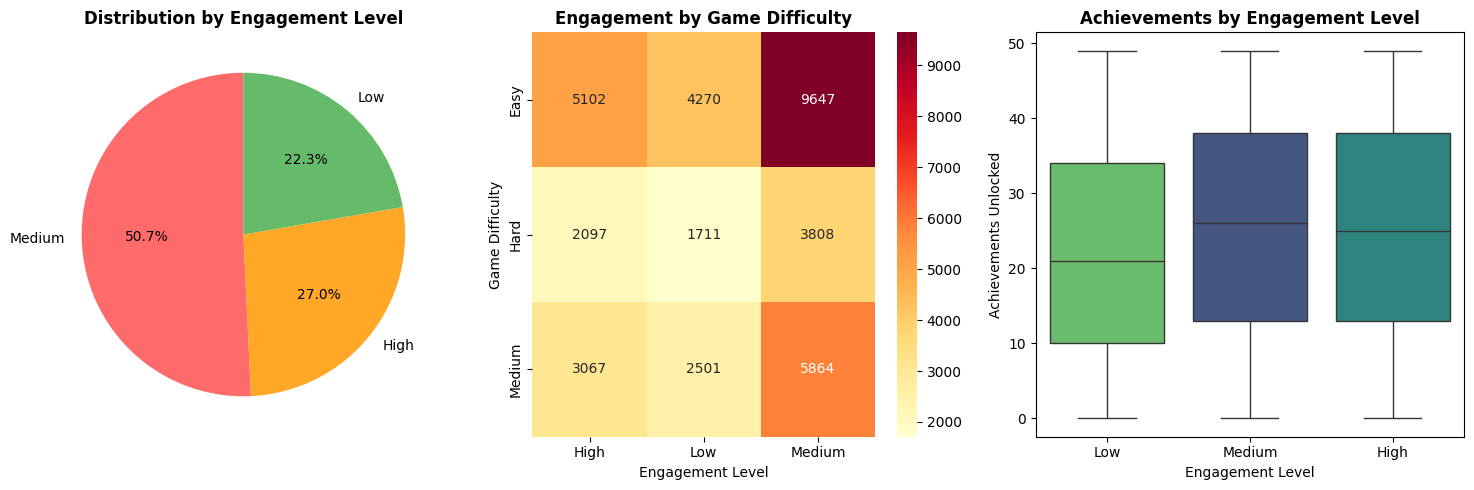

In [151]:
plt.figure(figsize=(15, 5))

# Engagement distribution
plt.subplot(1, 3, 1)
engagement_counts = df_visu['EngagementLevel'].value_counts()
colors = ['#FF6B6B', '#FFA726', '#66BB6A']
plt.pie(engagement_counts.values, labels=engagement_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Distribution by Engagement Level', fontweight='bold')

# Engagement by difficulty
plt.subplot(1, 3, 2)
engagement_difficulty = pd.crosstab(df_visu['GameDifficulty'], df_visu['EngagementLevel'])
sns.heatmap(engagement_difficulty, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Engagement by Game Difficulty', fontweight='bold')
plt.xlabel('Engagement Level')
plt.ylabel('Game Difficulty')

# Achievements by engagement
plt.subplot(1, 3, 3)
sns.boxplot(data=df_visu, x='EngagementLevel', y='AchievementsUnlocked',
           order=['Low', 'Medium', 'High'], palette='viridis', hue='EngagementLevel')
plt.title('Achievements by Engagement Level', fontweight='bold')
plt.xlabel('Engagement Level')
plt.ylabel('Achievements Unlocked')

plt.tight_layout()
plt.show()

### Behavioral Analysis

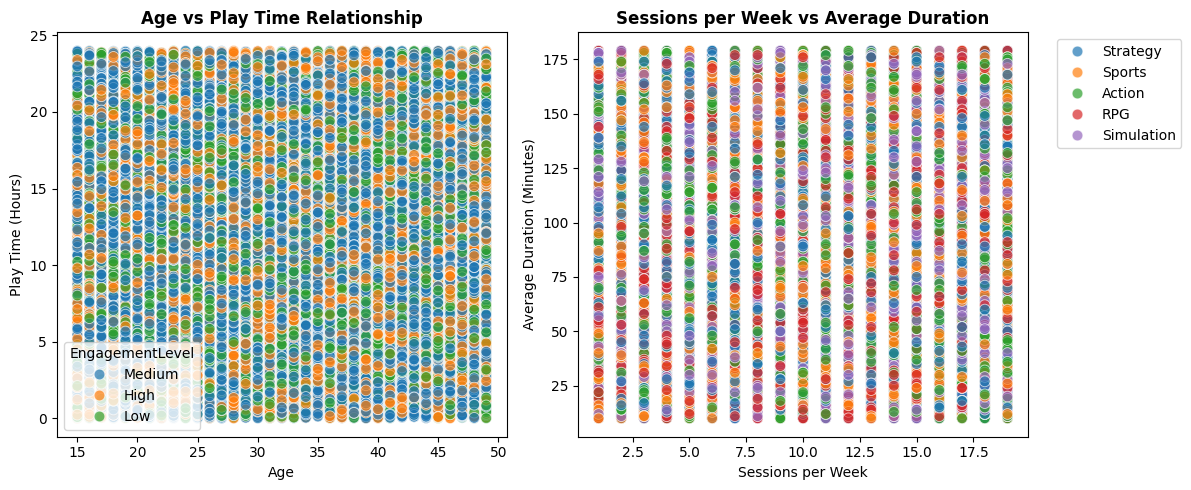

In [152]:
# Age vs play time relationship
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_visu, x='Age', y='PlayTimeHours', hue='EngagementLevel',
               alpha=0.7, s=60)
plt.title('Age vs Play Time Relationship', fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Play Time (Hours)')

# Sessions vs duration
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_visu, x='SessionsPerWeek', y='AvgSessionDurationMinutes',
               hue='GameGenre', alpha=0.7, s=60)
plt.title('Sessions per Week vs Average Duration', fontweight='bold')
plt.xlabel('Sessions per Week')
plt.ylabel('Average Duration (Minutes)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Location Analysis

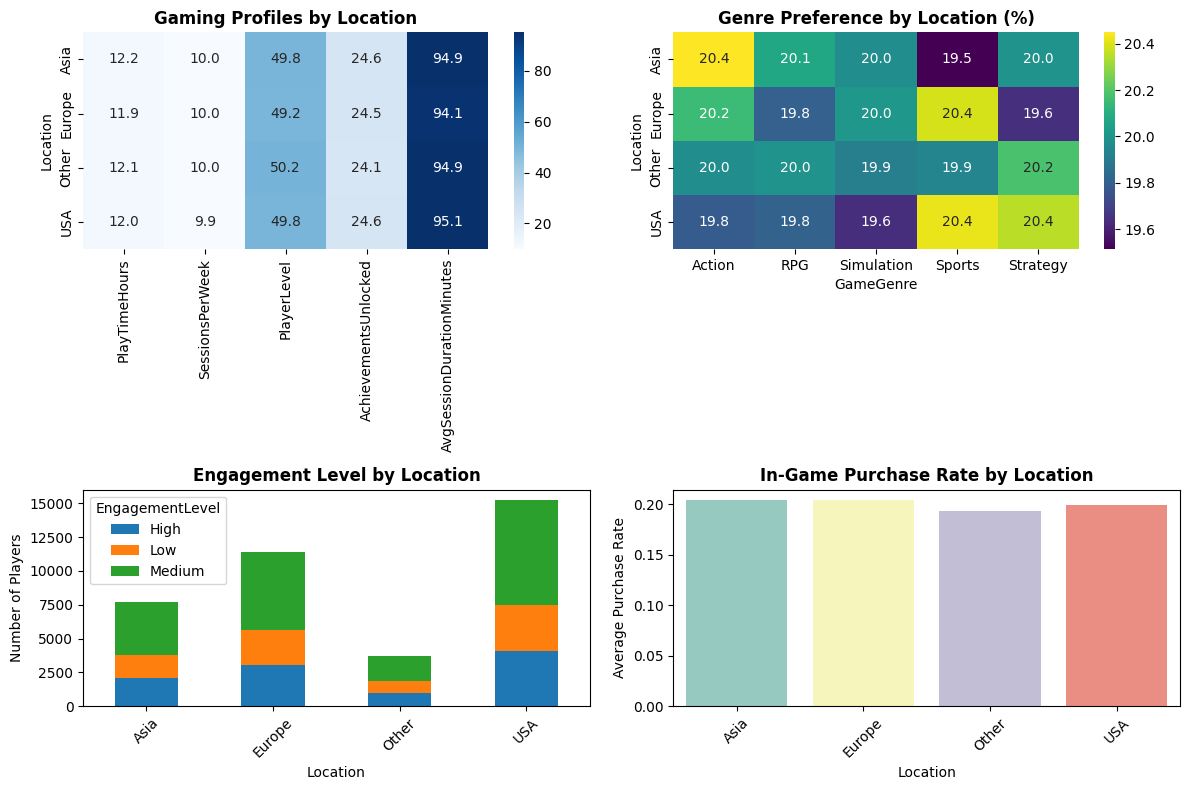

In [153]:
plt.figure(figsize=(12, 8))

# Gaming profiles by location
location_stats = df_visu.groupby('Location').agg({
    'PlayTimeHours': 'mean',
    'SessionsPerWeek': 'mean',
    'PlayerLevel': 'mean',
    'AchievementsUnlocked': 'mean',
    'AvgSessionDurationMinutes': 'mean'
}).round(2)

plt.subplot(2, 2, 1)
sns.heatmap(location_stats, annot=True, cmap='Blues', fmt='.1f')
plt.title('Gaming Profiles by Location', fontweight='bold')

# Genre preference by location
plt.subplot(2, 2, 2)
location_genre = pd.crosstab(df_visu['Location'], df_visu['GameGenre'])
location_genre_pct = location_genre.div(location_genre.sum(axis=1), axis=0) * 100
sns.heatmap(location_genre_pct, annot=True, fmt='.1f', cmap='viridis')
plt.title('Genre Preference by Location (%)', fontweight='bold')

# Engagement by location
plt.subplot(2, 2, 3)
location_engagement = pd.crosstab(df_visu['Location'], df_visu['EngagementLevel'])
location_engagement.plot(kind='bar', ax=plt.gca(), stacked=True)
plt.title('Engagement Level by Location', fontweight='bold')
plt.xlabel('Location')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)

# Purchases by location
plt.subplot(2, 2, 4)
purchase_by_location = df_visu.groupby('Location')['InGamePurchases'].mean()
sns.barplot(x=purchase_by_location.index, y=purchase_by_location.values, hue=purchase_by_location.index, palette='Set3')
plt.title('In-Game Purchase Rate by Location', fontweight='bold')
plt.xlabel('Location')
plt.ylabel('Average Purchase Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Advanced Analysis

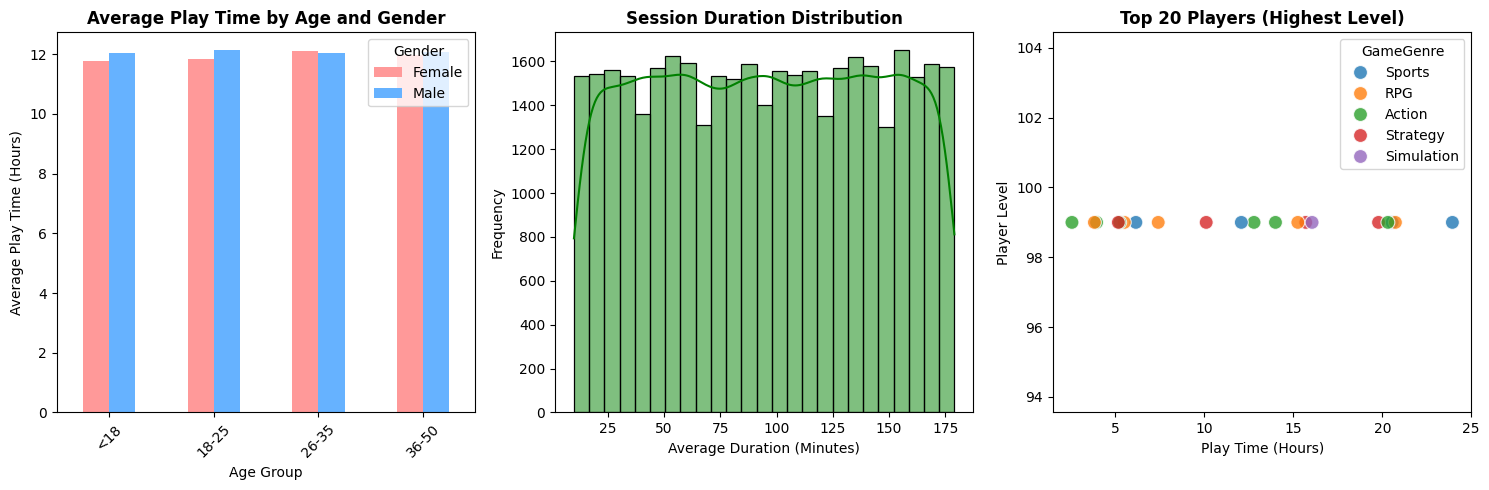

In [154]:
# Age group creation
df_visu['AgeGroup'] = pd.cut(df_visu['Age'], bins=[0, 18, 25, 35, 50],
                       labels=['<18', '18-25', '26-35', '36-50'])

plt.figure(figsize=(15, 5))

# Play time by age group and gender
plt.subplot(1, 3, 1)
age_gender_pivot = df_visu.pivot_table(values='PlayTimeHours', index='AgeGroup',
                                 columns='Gender', aggfunc='mean', observed=False)
age_gender_pivot.plot(kind='bar', ax=plt.gca(), color=['#FF9999', '#66B2FF'])
plt.title('Average Play Time by Age and Gender', fontweight='bold')
plt.xlabel('Age Group')
plt.ylabel('Average Play Time (Hours)')
plt.legend(title='Gender')
plt.xticks(rotation=45)

# Session duration distribution
plt.subplot(1, 3, 2)
sns.histplot(data=df_visu, x='AvgSessionDurationMinutes', bins=25, kde=True, color='green')
plt.title('Session Duration Distribution', fontweight='bold')
plt.xlabel('Average Duration (Minutes)')
plt.ylabel('Frequency')

# Top players (high level)
plt.subplot(1, 3, 3)
top_players = df_visu.nlargest(20, 'PlayerLevel')
sns.scatterplot(data=top_players, x='PlayTimeHours', y='PlayerLevel',
               hue='GameGenre', s=100, alpha=0.8)
plt.title('Top 20 Players (Highest Level)', fontweight='bold')
plt.xlabel('Play Time (Hours)')
plt.ylabel('Player Level')

plt.tight_layout()
plt.show()

### Correlation Heatmap

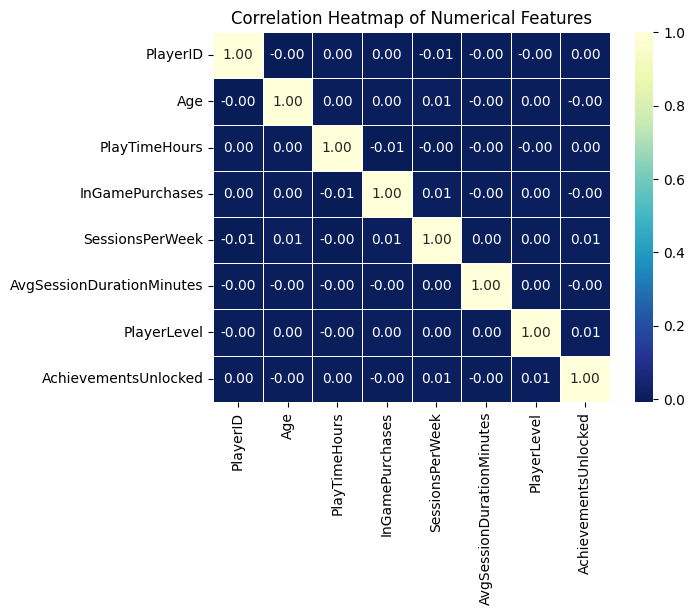

In [155]:
# Correlation heatmap
numerical_columns = df_visu.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_columns.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu_r", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## b) Seaborn Plots (Pair Plot, Heatmap, Correlation Matrix)

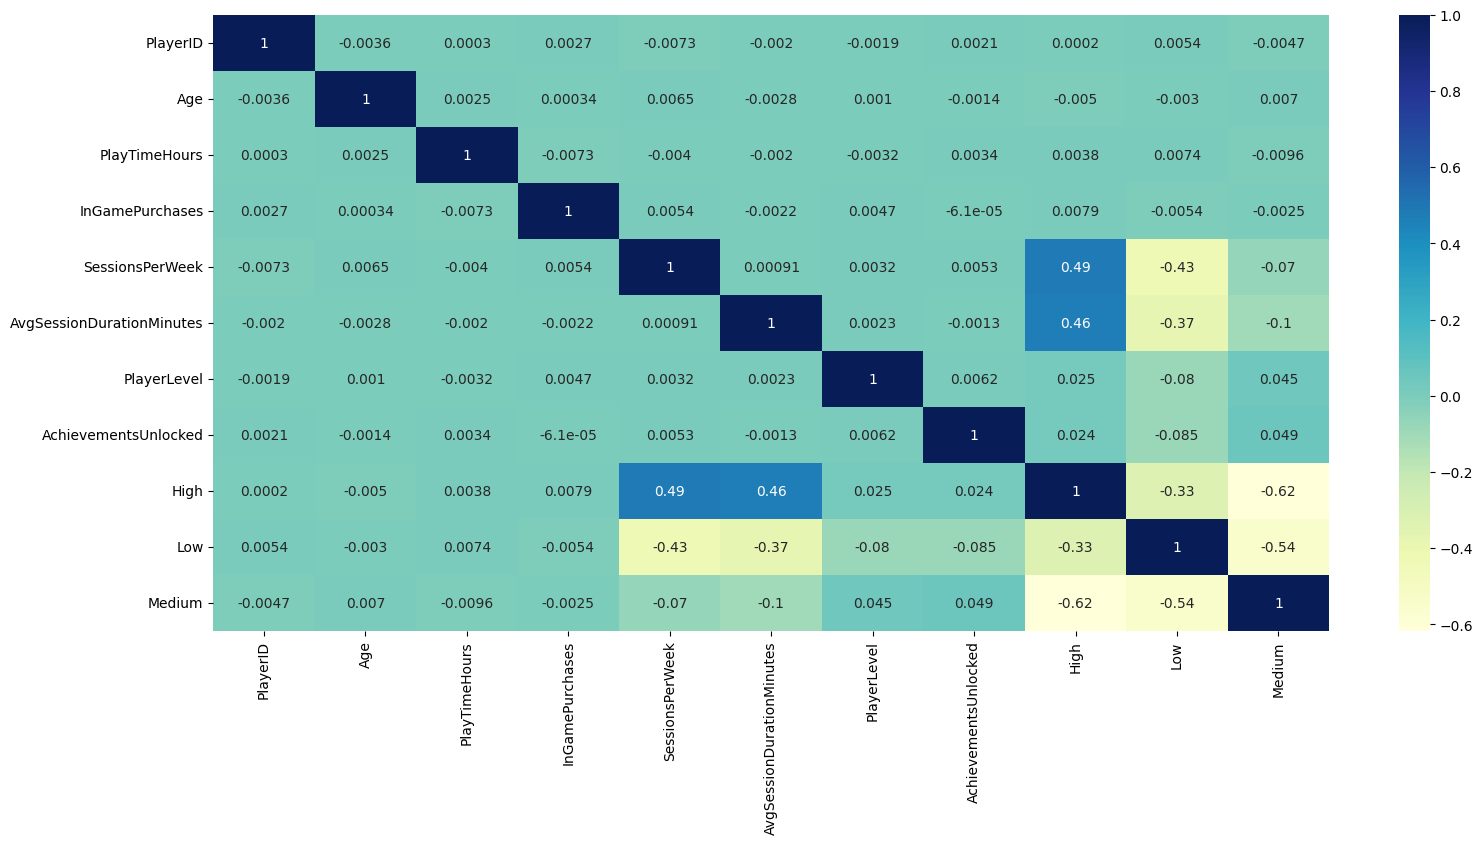

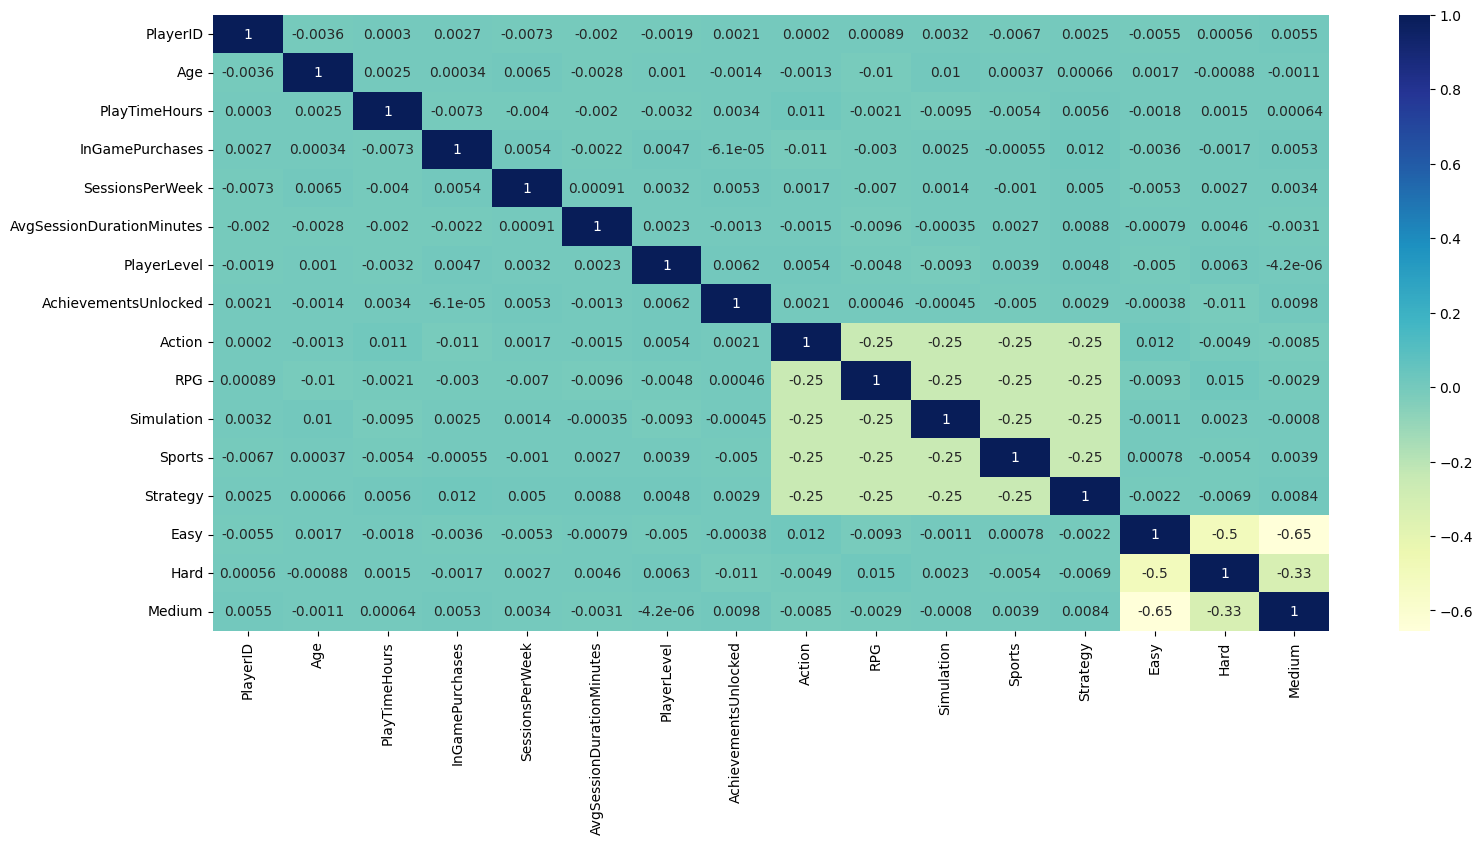

In [156]:
gender_country_data = df_visu.join(pd.get_dummies(df_visu.Gender)).drop(['Gender'], axis=1)
gender_country_data = df_visu.join(pd.get_dummies(df_visu.Location)).drop(['Location'], axis=1)
gender_country_data = df_visu.join(pd.get_dummies(df_visu.EngagementLevel)).drop(['EngagementLevel'], axis=1)

plt.figure(figsize=(18,8))
sns.heatmap(gender_country_data.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.show()

df_dummies = df_visu.join(pd.get_dummies(df_visu.GameGenre)).drop(['GameGenre'], axis=1)
df_dummies = df_dummies.join(pd.get_dummies(df_dummies.GameDifficulty)).drop(['GameDifficulty'], axis=1)
corr_matrix = df_dummies.corr(numeric_only=True)

plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

# 4) Feature Engineering

## a) Creation of 2 new features : EngagementEfficiency & SessionIntensity

In [157]:
# Create efficiency feature
print("We try creating a new feature representing the efficency of a player during is playtime :")
df['EngagementEfficiency'] = df['AchievementsUnlocked'] / df['PlayTimeHours']
df['EngagementEfficiency'] = df['EngagementEfficiency'].round(6)

# Create session intensity feature
print("With this new feature, we want to know if smaller regular sessions are more important than long rare sessions :")
df['SessionIntensity'] = df['SessionsPerWeek'] / df['AvgSessionDurationMinutes']
df['SessionIntensity'] = df['SessionIntensity'].round(6)

# We checked null values before so we don't need to apply .replace(0, something) there.

display(df[['PlayerID', 'PlayTimeHours', 'AchievementsUnlocked', 'EngagementEfficiency', 'SessionIntensity']].head(10))

We try creating a new feature representing the efficency of a player during is playtime :
With this new feature, we want to know if smaller regular sessions are more important than long rare sessions :


,PlayerID,PlayTimeHours,AchievementsUnlocked,EngagementEfficiency,SessionIntensity
0,9000,16.271119,25,1.536465,0.055556
1,9001,5.525961,10,1.809640,0.034722
2,9002,8.223755,41,4.985557,0.112676
3,9003,5.265351,47,8.926280,0.105882
4,9004,15.531945,37,2.382187,0.015267
5,9005,20.561855,22,1.069942,0.024691
6,9006,9.752716,2,0.205071,0.020000
7,9007,4.401729,23,5.225219,0.208333
8,9008,18.152733,41,2.258613,0.049505
9,9009,23.942772,36,1.503585,0.136842


## b) Normalization of the data

In [158]:
# Normalize continuous features
scaler = StandardScaler()
numerical_features = ['PlayerLevel', 'PlayTimeHours', 'AvgSessionDurationMinutes', 'SessionsPerWeek', 'AchievementsUnlocked', 'EngagementEfficiency', 'SessionIntensity']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

display(df.head(10))

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,...,GameGenre_Action,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Easy,GameDifficulty_Hard,GameDifficulty_Medium,EngagementEfficiency,SessionIntensity
0,9000,43,Male,Other,Strategy,0.613904,0,Medium,-0.722488,0.270265,...,0,0,0,0,1,0,0,1,-0.015002,-0.541747
1,9001,29,Female,USA,Strategy,-0.939354,0,Medium,-0.904879,1.004529,...,0,0,0,0,1,0,0,1,-0.014772,-0.639250
2,9002,22,Female,USA,Sports,-0.549376,0,Easy,1.101423,0.963736,...,0,0,0,1,0,1,0,0,-0.012104,-0.274424
3,9003,35,Male,USA,Action,-0.977026,1,Easy,-0.175314,-0.198847,...,1,0,0,0,0,1,0,0,-0.008793,-0.306220
4,9004,33,Male,Europe,Action,0.507054,0,Medium,-1.452052,0.739378,...,1,0,0,0,0,0,0,1,-0.014291,-0.730300
5,9005,37,Male,Europe,RPG,1.234149,0,Easy,-1.452052,-0.280432,...,0,1,0,0,0,1,0,0,-0.015394,-0.686195
6,9006,25,Male,USA,Action,-0.328358,0,Hard,-1.634443,-0.912714,...,1,0,0,0,0,0,1,0,-0.016120,-0.708149
7,9007,25,Female,Asia,RPG,-1.101866,0,Medium,0.007077,-0.953507,...,0,1,0,0,0,0,0,1,-0.011902,0.173253
8,9008,38,Female,Europe,Simulation,0.885900,0,Easy,-0.904879,0.127492,...,0,0,1,0,0,1,0,0,-0.014395,-0.570065
9,9009,38,Female,Other,Sports,1.722875,0,Easy,0.554250,0.005115,...,0,0,0,1,0,1,0,0,-0.015029,-0.161326


## c) Displaying the modifications

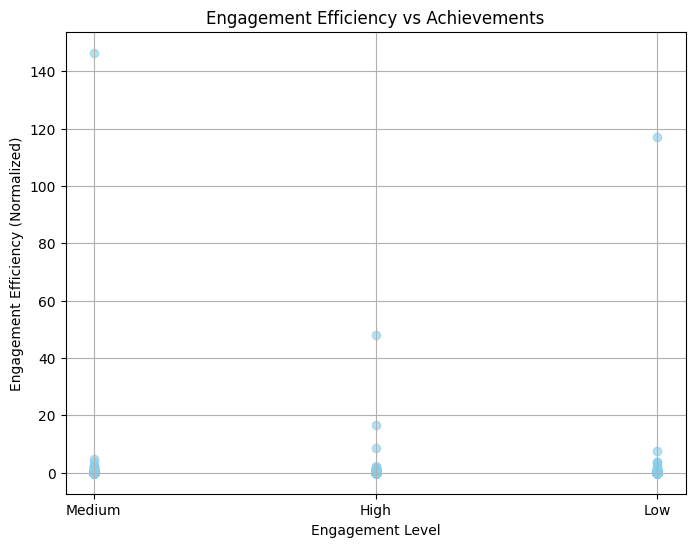

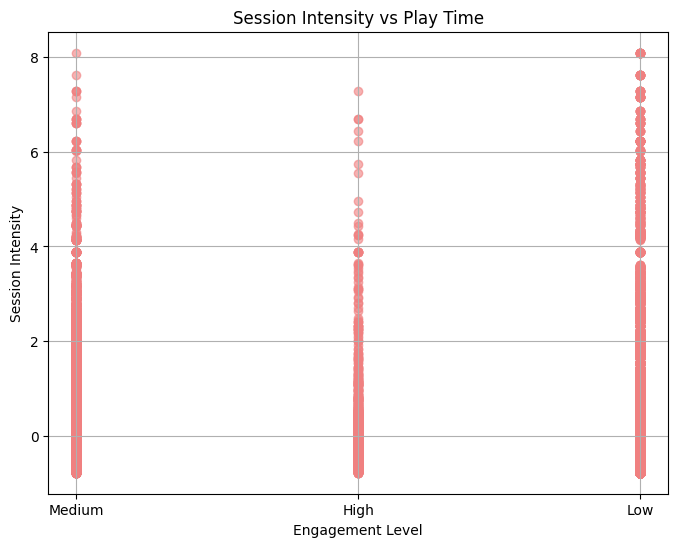

Let's discover their level of correlation to the 'EngagementLevel' :
EngagementEfficiency correlation: -0.000 (p=0.977)
SessionIntensity correlation: 0.077 (p=0.000)


In [159]:
# Plot efficiency vs achievements
plt.figure(figsize=(8, 6))
plt.scatter(df['EngagementLevel'], df['EngagementEfficiency'], color='skyblue', alpha=0.6)
plt.title('Engagement Efficiency vs Achievements')
plt.xlabel('Engagement Level')
plt.ylabel('Engagement Efficiency (Normalized)')
plt.grid(True)
plt.show()

# Plot session intensity vs play time
plt.figure(figsize=(8, 6))
plt.scatter(df['EngagementLevel'], df['SessionIntensity'], color='lightcoral', alpha=0.6)
plt.title('Session Intensity vs Play Time')
plt.xlabel('Engagement Level')
plt.ylabel('Session Intensity')
plt.grid(True)
plt.show()

# We check the correlation to the EngagementLevel :
print("Let's discover their level of correlation to the 'EngagementLevel' :")
new_features = ['EngagementEfficiency', 'SessionIntensity']

for new_feature in new_features :
    corr_efficiency, p_val = pearsonr(df[new_feature], pd.Categorical(df['EngagementLevel']).codes)
    print(f"{new_feature} correlation: {corr_efficiency:.3f} (p={p_val:.3f})")

# 5) ML Model

## a) Setup Random Forest

In [160]:
# target
target_column = 'EngagementLevel'

# seperate x y
X = df.drop(columns=[target_column, 'Gender', 'Location', 'GameGenre', 'GameDifficulty'])
y = df[target_column]

# split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# random forest
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=15,
    min_samples_leaf=8,
    random_state=42
)

model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9003152088258471

Classification Report:
               precision    recall  f1-score   support

        High       0.92      0.86      0.89      2053
         Low       0.91      0.82      0.86      1697
      Medium       0.89      0.95      0.92      3864

    accuracy                           0.90      7614
   macro avg       0.91      0.88      0.89      7614
weighted avg       0.90      0.90      0.90      7614



## b) Macro-Micro Score

In [161]:
from sklearn.metrics import f1_score

# macro micro f1
report = classification_report(y_test, y_pred, output_dict=True)
macro_f1 = report['macro avg']['f1-score']
micro_f1 = f1_score(y_test, y_pred, average='micro')

print("Macro F1-score:", macro_f1)
print("Micro F1-score:", micro_f1)

Macro F1-score: 0.8912123820560104
Micro F1-score: 0.9003152088258471


## c) Confusion Matrix

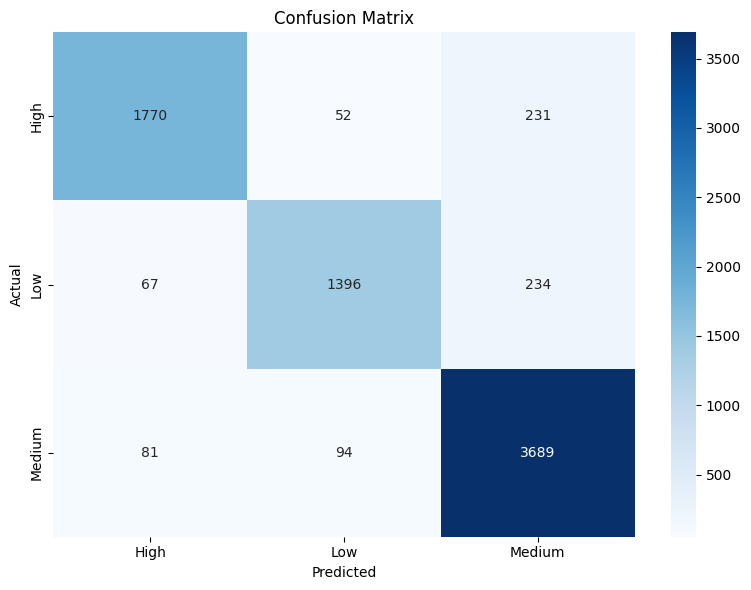

In [162]:
# confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# feature importance
importances = model.feature_importances_
feat_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

## d) Top 15 Feature


Top 15 features:

                      Feature  Importance
5   AvgSessionDurationMinutes    0.334772
4             SessionsPerWeek    0.333091
23           SessionIntensity    0.215534
6                 PlayerLevel    0.021120
7        AchievementsUnlocked    0.017342
22       EngagementEfficiency    0.016964
0                    PlayerID    0.014861
2               PlayTimeHours    0.014641
1                         Age    0.010968
19        GameDifficulty_Easy    0.001876
13               Location_USA    0.001875
8               Gender_Female    0.001681
9                 Gender_Male    0.001574
21      GameDifficulty_Medium    0.001562
11            Location_Europe    0.001552


C:\Users\alyog\AppData\Local\Temp\ipykernel_30964\161889655.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')


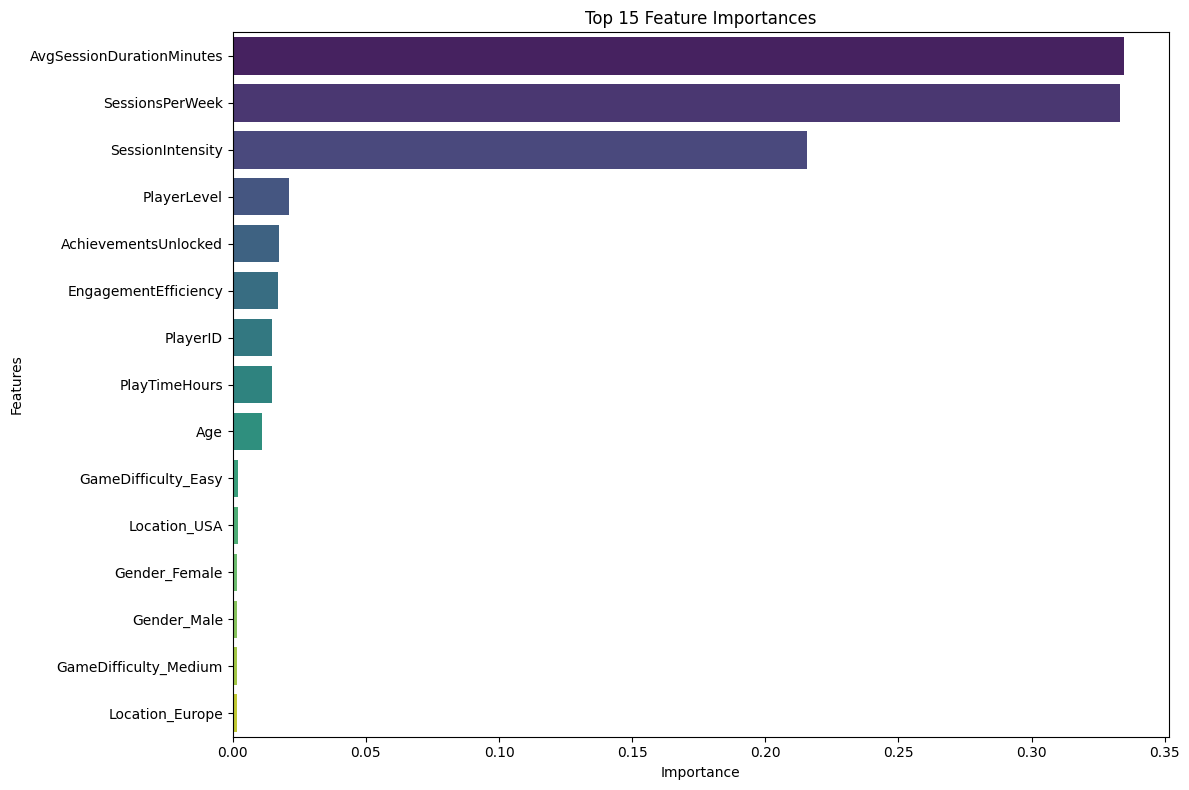

In [163]:
# print
print("\nTop 15 features:\n")
print(importance_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## e) Cross Validation

In [164]:
# cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Cross-validation Accuracy: 0.894 (+/- 0.006)


# 6) Responsible AI Practices

In [165]:
# Data Privacy Check
print("--- Data Privacy ---")
print(f"Dataset contains {len(df)} player records")
print("Sensitive data handling:")
print("- Player IDs are anonymized")
print("- No personal information stored")
print("- Data used only for engagement analysis\n")

# 2. Bias Detection
print("--- Bias Analysis ---")

print("Gender distribution:")
print(df['Gender'].value_counts(normalize=True))

print("\nLocation distribution:")
print(df['Location'].value_counts(normalize=True))

# 3. Transparency

print(f"\n--- Model Transparency ---")
print("Model used: Random Forest")
print(f"Number of trees: {model.n_estimators}")
print(f"Max depth: {model.max_depth}")
print("Key features influencing predictions:")
print(importance_df.head(3)[['Feature', 'Importance']])

print("=== RESPONSIBLE AI PRACTICES ===\n")

# 1. Data Privacy
print("--- Data Privacy ---")
print("- Dataset is publicly available (Kaggle)")
print("- Player IDs are visible but anonymous")
print("- Location data is general, not precise")
print("- No biometric or financial information\n")

# 2. Bias Analysis
print("--- Bias Analysis ---")
engagement_by_gender = pd.crosstab(df['Gender'], df['EngagementLevel'], normalize='index')
print("Engagement by gender:")
print(engagement_by_gender.round(3))

engagement_by_location = pd.crosstab(df['Location'], df['EngagementLevel'], normalize='index')
print("\nEngagement by location:")
print(engagement_by_location.round(3))

from scipy.stats import chi2_contingency
chi2, p_val, _, _ = chi2_contingency(pd.crosstab(df['Gender'], df['EngagementLevel']))
print(f"\nGender-Engagement independence test p-value: {p_val:.3f}")
if p_val < 0.05:
    print("- Potential bias detected")
else:
    print("- No significant bias found")

# 3. Model Fairness
print("\n--- Model Fairness ---")
for gender in df['Gender'].unique():
    mask = (X_test.index.isin(df[df['Gender'] == gender].index))
    if mask.sum() > 0:
        gender_accuracy = accuracy_score(y_test[mask], y_pred[mask])
        print(f"- Accuracy for {gender}: {gender_accuracy:.3f}")

print("! Disclaimer ! :")
print("- Simulated dataset, not real user data")
print("- Model not tested under real-world conditions")

--- Data Privacy ---
Dataset contains 38067 player records
Sensitive data handling:
- Player IDs are anonymized
- No personal information stored
- Data used only for engagement analysis

--- Bias Analysis ---
Gender distribution:
Gender
Male      0.598997
Female    0.401003
Name: proportion, dtype: float64

Location distribution:
Location
USA       0.400373
Europe    0.299419
Asia      0.202196
Other     0.098011
Name: proportion, dtype: float64

--- Model Transparency ---
Model used: Random Forest
Number of trees: 200
Max depth: 15
Key features influencing predictions:
                      Feature  Importance
5   AvgSessionDurationMinutes    0.334772
4             SessionsPerWeek    0.333091
23           SessionIntensity    0.215534
=== RESPONSIBLE AI PRACTICES ===

--- Data Privacy ---
- Dataset is publicly available (Kaggle)
- Player IDs are visible but anonymous
- Location data is general, not precise
- No biometric or financial information

--- Bias Analysis ---
Engagement by gen